In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers

In [2]:
BATCH_SIZE = 32
IMG_SIZE = 256

In [3]:
def getDataset(dirc,IMG_SIZE , BATCH_SIZE):
    Dataset = tf.keras.preprocessing.image_dataset_from_directory(dirc , image_size = (IMG_SIZE , IMG_SIZE) , seed=1 , batch_size=BATCH_SIZE )
    return Dataset

In [4]:
trainDataset = getDataset('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training',IMG_SIZE , BATCH_SIZE)
validationDataset = getDataset('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation',IMG_SIZE , BATCH_SIZE)
testDataset = getDataset('/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing',IMG_SIZE , BATCH_SIZE)

Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


In [5]:
class_names = trainDataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

In [6]:
# 102 batch : each batch have 32 image
# 13 batch : each batch have 32 image
# 13 batch : each batch have 32 image
print("train len : " , len(trainDataset))
print("validation len : " , len(validationDataset))
print("test len : " , len(testDataset))

train len :  102
validation len :  13
test len :  13


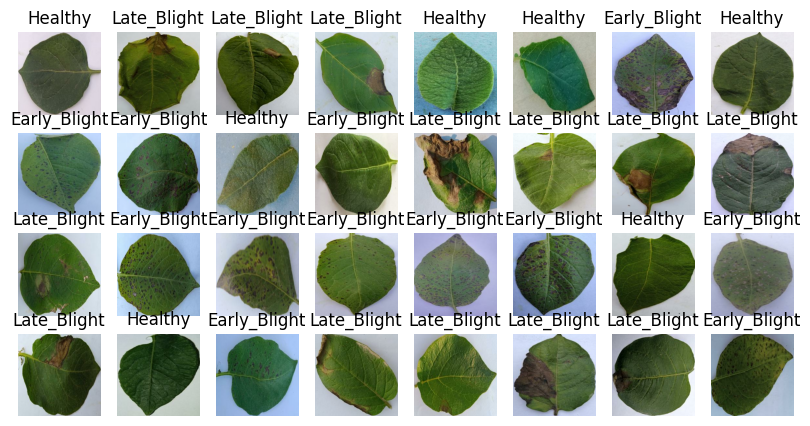

In [7]:
fig = plt.figure(figsize=(10,5))
for image , label in trainDataset.take(1):
    for i in range(32):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(np.array(image[i]).astype(np.uint8))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [8]:
# prefetch data : if gpu is busy , cpu will get other batches from disk
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validationDataset = validationDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
# preporcessing 
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255.0),
])
# data augmentation
randomFlip_randomRotation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
# create model
model = models.Sequential([
    resize_rescale,
    randomFlip_randomRotation,
    layers.Conv2D(32 , (3,3) , activation='relu' , input_shape=(BATCH_SIZE ,IMG_SIZE , IMG_SIZE , 3) ),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64 , (3,3) , activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64 , activation='relu'),
    layers.Dense(3 , activation = 'softmax'),
])
model.build(input_shape=(BATCH_SIZE , IMG_SIZE , IMG_SIZE , 3))

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(optimizer='adam' , loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) , metrics=['accuracy'])

In [13]:
history = model.fit(trainDataset , epochs=20 , batch_size=BATCH_SIZE , verbose=1 , validation_data=validationDataset)

Epoch 1/20
102/102 [==============================] - 270s 3s/step - loss: 0.9673 - accuracy: 0.5094 - val_loss: 0.8090 - val_accuracy: 0.6538
Epoch 2/20
102/102 [==============================] - 259s 3s/step - loss: 0.6065 - accuracy: 0.7641 - val_loss: 0.5855 - val_accuracy: 0.7404
Epoch 3/20
102/102 [==============================] - 258s 3s/step - loss: 0.4005 - accuracy: 0.8524 - val_loss: 0.3078 - val_accuracy: 0.8894
Epoch 4/20
102/102 [==============================] - 261s 3s/step - loss: 0.3149 - accuracy: 0.8883 - val_loss: 0.3445 - val_accuracy: 0.8534
Epoch 5/20
102/102 [==============================] - 262s 3s/step - loss: 0.2431 - accuracy: 0.9182 - val_loss: 0.1972 - val_accuracy: 0.9183
Epoch 6/20
102/102 [==============================] - 261s 3s/step - loss: 0.2079 - accuracy: 0.9311 - val_loss: 0.2664 - val_accuracy: 0.8822
Epoch 7/20
102/102 [==============================] - 260s 3s/step - loss: 0.1786 - accuracy: 0.9416 - val_loss: 0.2241 - val_accuracy: 0.9014

In [14]:
score = model.evaluate(testDataset)

13/13 [==============================] - 9s 652ms/step - loss: 0.1187 - accuracy: 0.9654


In [15]:
score

[0.1187209039926529, 0.9654321074485779]

In [16]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 102}

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

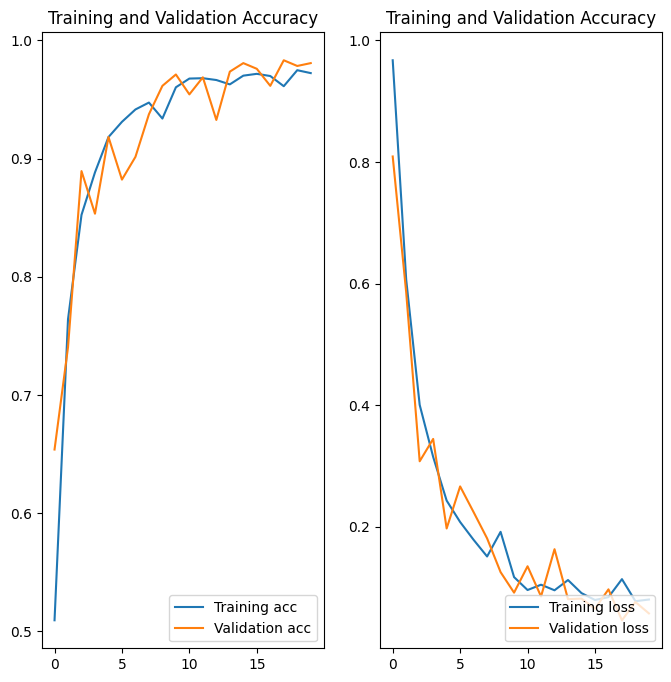

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot( range(20) , acc , label="Training acc" )
plt.plot( range(20) , val_acc , label="Validation acc" )
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot( range(20) , loss , label="Training loss" )
plt.plot( range(20) , val_loss , label="Validation loss" )
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

predict image
1/1 [==============================] - 1s 888ms/step
predicted label :  Late_Blight


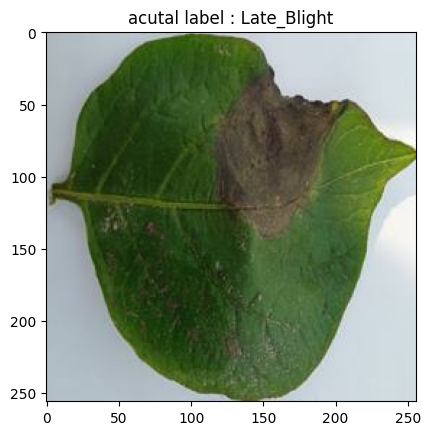

In [20]:
for image , label in testDataset.take(1):
    f_image = image[0].numpy().astype('uint8')
    f_label = label[0].numpy()
    
    print("predict image")
    plt.imshow(f_image)
    plt.title("acutal label : "+str(class_names[f_label]) ) 
    
    prediction = model.predict(image)
    print("predicted label : " , class_names[np.argmax(prediction[0])] ) 

In [21]:
def predictImage(model,  img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array , 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions)) , 2)
    return predicted_class,confidence

1/1 [==============================] - 0s 41ms/step


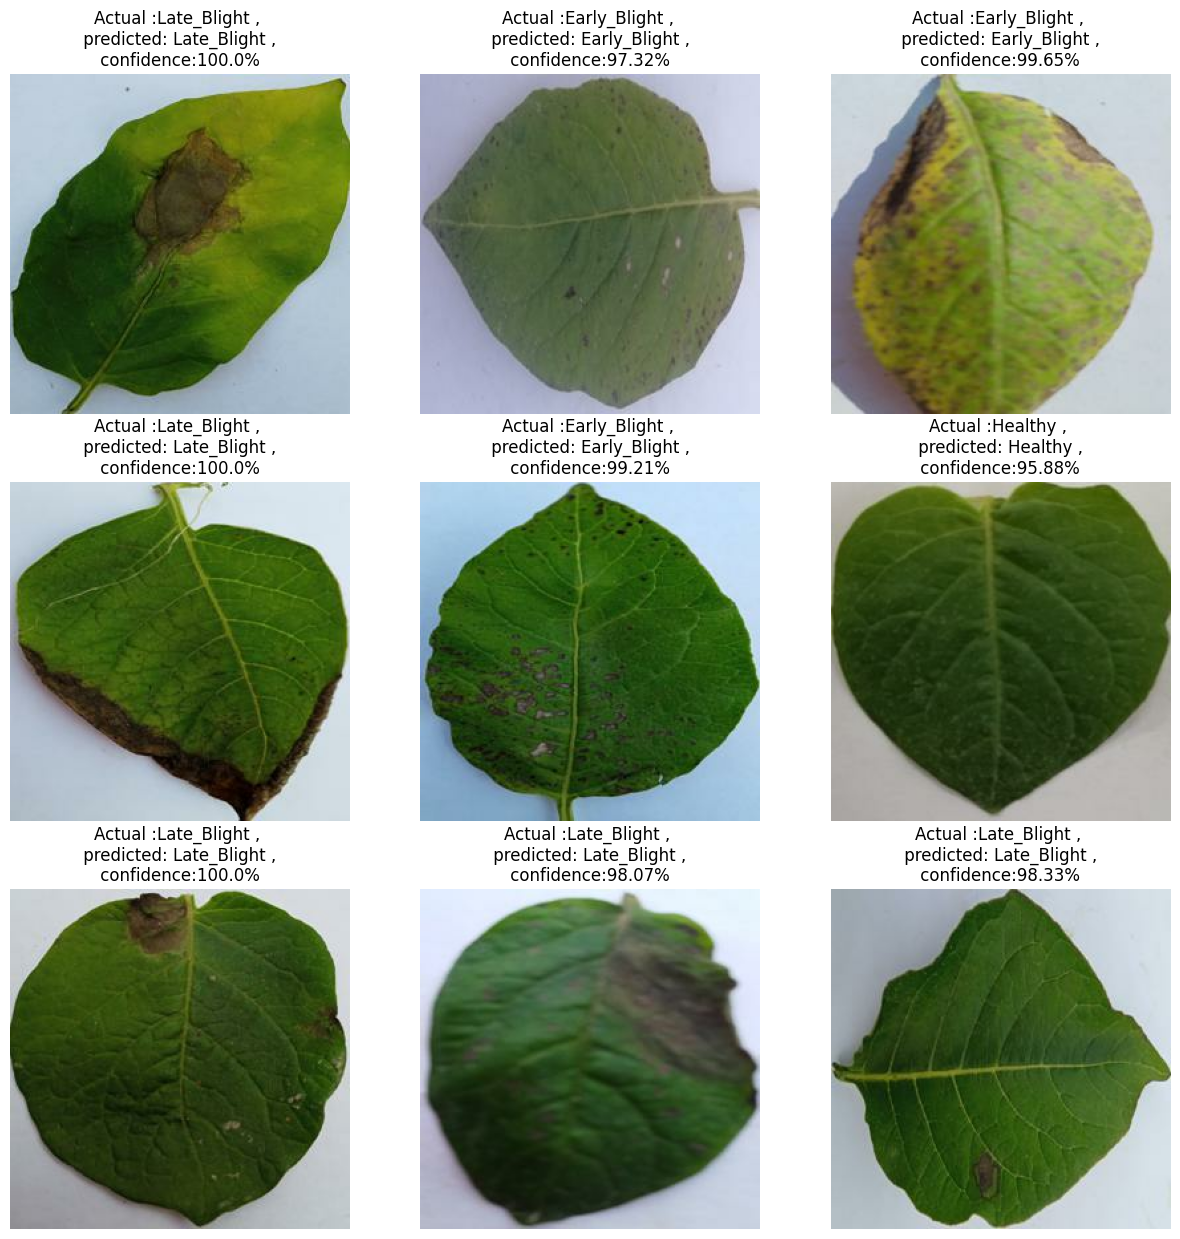

In [22]:
plt.figure(figsize=(15,15))
for image,label in testDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        predicted_class,confidence = predictImage(model , image[i])
        actual_class = class_names[label[i]]
        plt.title(f"Actual :{actual_class} , \n predicted: {predicted_class} , \n confidence:{confidence}% " )
        plt.axis('off')

In [23]:
# save model
#import os
#model_version=max([int(i) for i in os.listdir("savedModels")+[0]  ])+1
tf.keras.models.save_model(model , "model.pbtxt")

In [24]:
# load model
model = tf.keras.models.load_model('model.pbtxt')

In [25]:
# save model_tflite to tensorflow lite file
open("cnnModel.tflite","wb").write(model_tflite)

NameError: name 'model_tflite' is not defined

In [ ]:
# convert model tensorflow to tensorflow lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_tflite = converter.convert()